In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import urllib as urllib
from tqdm import tqdm_notebook as tqdm
import gzip
import timeit

sys.path.append(os.path.abspath('..\\dataset'))
sys.path.append(os.path.abspath('..'))
import dataset as ds
from dataset.models.tf import VGG16
from dataset.opensets import MNIST
from dataset import B, V
PATH_TO_MNIST = os.path.join('..', 'datasets', 'MNIST')

## VGG 16

In [2]:
mnist_set = MNIST(batch_class = ds.ImagesBatch)


def get_ppl_vgg(image_size):
    placeholders_config = {'images': {'shape':image_size,
                                     'name': 'resized_images'},
                           'labels': {'classes' : 10,
                                      'transform': 'ohe',
                                      'name': 'targets'}}

    vgg_config = {'inputs': placeholders_config,
                  'loss' : 'ce',
                  'input_block/inputs': 'images',
                  'output': dict(ops=['labels', 'accuracy'], data_format='channels_last'),
                  'head/units' : [500,500,2]
                 }

    return (mnist_set.train.p
                         .init_variable('acc_history', init_on_each_run=list)
                         .init_model('dynamic', VGG16, 'vgg16', config=vgg_config)
                         .resize(shape=image_size[:2])
                         .train_model('vgg16', fetches='accuracy', feed_dict={'images': B('images'),
                                                                              'labels': B('labels')},
                                      save_to=V('acc_history'), mode='a'))

ExtractingExtractingExtracting Extracting C:\Users\ROMANK~1\AppData\Local\Temp\train-images-idx3-ubyte.gz  
C:\Users\ROMANK~1\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\ROMANK~1\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\ROMANK~1\AppData\Local\Temp\t10k-images-idx3-ubyte.gz




In [52]:
def measure_time_execution(func, n_experiments):
    stat = []
    for _ in (range(n_experiments)):
        stat.append(timeit.timeit(get_batch, number = 1))
    return np.mean(stat), np.std(stat)

In [54]:
image_sizes = [(size,size,1) for size in range(1, 112, 5)]

In [55]:
means = []
stds = []
batch_size = 64

for size in tqdm(image_sizes):
    ppl = get_ppl_vgg(size)
    ppl.next_batch(batch_size=batch_size, shuffle=True, n_epochs=None)
    get_batch = lambda x=0 : ppl.next_batch(batch_size=batch_size, shuffle=True, n_epochs=None)
    mean, std = measure_time_execution(get_batch, n_experiments = 30)
    means.append(mean)
    stds.append(std)
    
means=np.array(means)
stds = np.array(stds)

A Jupyter Widget

C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Text(0,0.5,'seconds')

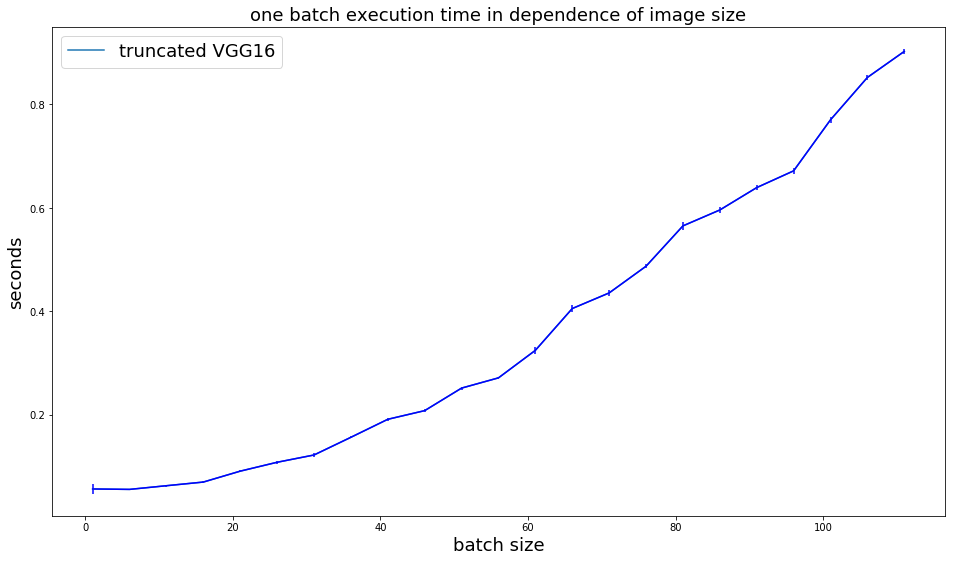

In [56]:
x = [i[0] for i in image_sizes]
plt.figure(figsize=(16,9))
plt.plot(x,means, label='truncated VGG16')
plt.errorbar(x, means, yerr=2*stds, c='blue')
plt.title('one batch execution time in dependence of image size', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('batch size', fontsize=18)
plt.ylabel('seconds', fontsize=18)

## looks like $n\ln n$, let's check it

>It is assumed that $y = ax^b(\ln x)^c \Rightarrow \ln y = \ln a + b \ln x + c \ln \ln x$

In [78]:
from sklearn.linear_model import Ridge
xaug = np.array(x).reshape(-1,1)[2:]
xaug = np.hstack((np.log(xaug),np.log(np.log(xaug))))
linreg = Ridge(0.00001).fit(xaug, np.log(means[2:]-means[0] ))

In [79]:
b, c =  linreg.coef_ 
a= np.exp(linreg.intercept_),

In [80]:
print('R squared', linreg.score(xaug, np.log(means[2:]-means[0] )))

R squared 0.9975760581


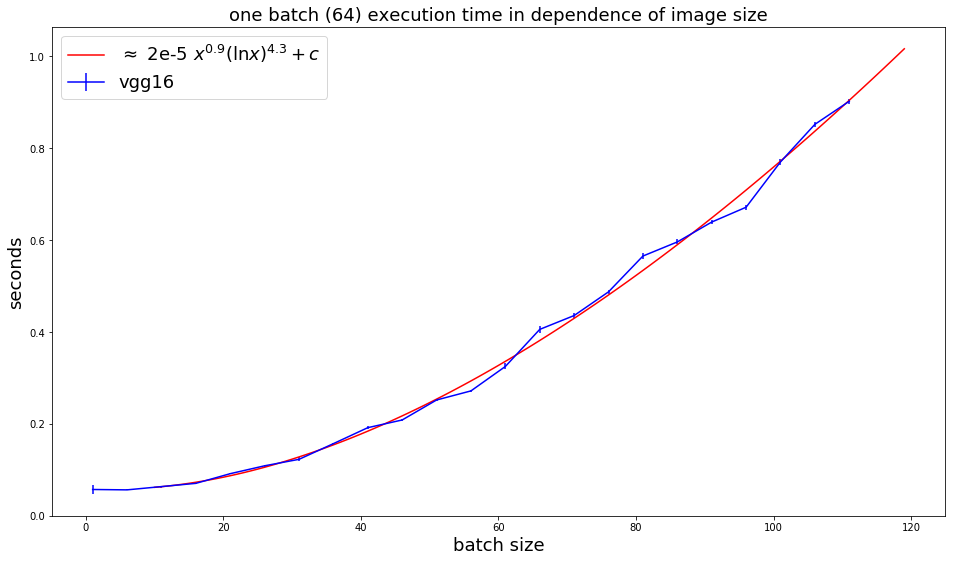

In [87]:
x = [i[0] for i in image_sizes]
plt.figure(figsize=(16,9))
plt.errorbar(x, means, yerr=2*stds, c='blue', label='vgg16')
plt.title('one batch (64) execution time in dependence of image size', fontsize=18)
plt.xlabel('batch size', fontsize=18)
plt.ylabel('seconds', fontsize=18)

xx = np.arange(10,120,1)
plt.plot(xx, (xx ** b) * (np.log(xx)**c) * a + means[0], label=r'$\approx$ 2e-5 $x^{0.9} (\ln x)^{4.3} + c$', c='red')
plt.legend(fontsize=18)


## Resnet


array([[  1,   1],
       [ 11,  11],
       [ 21,  21],
       [ 31,  31],
       [ 41,  41],
       [ 51,  51],
       [ 61,  61],
       [ 71,  71],
       [ 81,  81],
       [ 91,  91],
       [101, 101]])

In [21]:
lreg.intercept_


-0.054098184270105265

C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


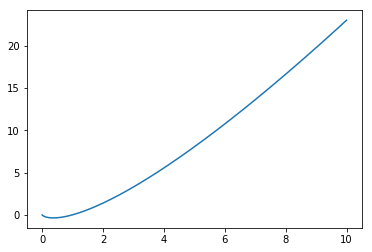

In [20]:
xx = np.arange(0, 10, 0.001)
plt.plot(xx, xx * np.log(xx))

In [28]:
((2,3),1)

((2, 3), 1)

In [40]:
get_batch()